# Create an interface between two materials with minimal strain

Use Zur and McGill superlattices matching [algorithm](https://doi.org/10.1063/1.3330840) to create interfaces between two materials using the Pymatgen [implementation](https://pymatgen.org/pymatgen.analysis.interfaces.html#pymatgen.analysis.interfaces.zsl).

<h2 style="color:green">Usage</h2>

0. Make sure to select Input Materials
1. Execute "Run first: ..." cell below to load Input Materials into the current kernel
2. Set Input Parameters (e.g. `MILLER_INDICES`, `THICKNESS`, `MAX_AREA`) below or use the default values
3. Click "Run" > "Run All" to run all cells
4. Wait for the run to complete (depending on the area, it can take 1-2 min or more). Scroll down to view cell results.
5. Review the strain plot and modify its parameters as needed

## Methodology

The following happens in the script below:

1. Create slabs for each input material. The materials data is passed in from and back to the web application according to this description (TBA).
   We assume that two input materials are either in bulk form (e.g. Ni crystal) or layered (e.g. graphene). 
   
   We construct the interface along the Z-axis. The material corresponding to the bottom of the interface is referred to as the "**substrate**", and the top - as the "**layer**". 

2. Perform strain matching on the slabs to extract the supercell dimensions. The algorithm has a set of parameters, such as the maximum area considered, that can be configured by editing the cells below.

3. When the strain matching is finished, the interface with the lowest strain (and the smallest number of atoms) is selected. We create the corresponding supercells and place them at a specified distance from each other (note no shift is performed currently).


<h2 style="color:red">Run first: load input materials in current kernel</h2>


In [17]:
import json
materials_in = []
for file in ["Ni.json", "Gr.json"]:
    with open(file, "r") as f:
        data = f.read()
        materials_in.append(json.loads(data))

## 1. Set Input Parameters

### 1.1. Select Substrate and Layer from Input Materials

In [18]:
SUBSTRATE_PARAMETERS = {
    "MATERIAL_INDEX": 0,  # the index of the material in the materials_in list
    "MILLER_INDICES": (1, 1, 1),  # the miller indices of the interfacial plane
    "THICKNESS": 3,  # in layers
}

LAYER_PARAMETERS = {
    "MATERIAL_INDEX": 1, # the index of the material in the materials_in list
    "MILLER_INDICES": (0, 0, 1),  # the miller indices of the interfacial plane
    "THICKNESS": 1,  # in layers
}

### 1.2. Set Interface Parameters

The distance between layer and substrate and maximum area to consider when matching.


In [19]:
INTERFACE_PARAMETERS = {
    "DISTANCE_Z": 3.0, # in Angstroms
    "MAX_AREA": 50, # in Angstroms^2
}

### 1.3. Set Algorithm Parameters

In [20]:
ZSL_PARAMETERS = {
    "MAX_AREA": INTERFACE_PARAMETERS["MAX_AREA"],  # The area to consider in Angstrom^2
    "MAX_AREA_TOL": 0.09,  # The area within this tolerance is considered equal
    "MAX_LENGTH_TOL": 0.03,  # supercell lattice vectors lengths within this tolerance are considered equal
    "MAX_ANGLE_TOL": 0.01,  # supercell lattice angles within this tolerance are considered equal
    "STRAIN_TOL": 10e-6,  # strains within this tolerance are considered equal
}

## 2. Install Packages

In [21]:
!python --version
!pip list
# !pip install pymatgen==2024.2.8 ase==3.22.1 nbformat==5.9.2 ipykernel==6.29.2 matgl==0.9.2 nglview==3.1.1 alignn==2024.2.4 pip install PyQt5==5.15.10

Python 3.11.7


Package                    Version
-------------------------- -----------------
accelerate                 0.27.2
aiohttp                    3.9.3
aiosignal                  1.3.1
alignn                     2024.2.4
anyio                      4.3.0
appnope                    0.1.4
argon2-cffi                23.1.0
argon2-cffi-bindings       21.2.0
arrow                      1.3.0
ase                        3.22.1
asttokens                  2.4.1
async-lru                  2.0.4
attrs                      23.2.0
Babel                      2.14.0
beautifulsoup4             4.12.3
bleach                     6.1.0
certifi                    2024.2.2
cffi                       1.16.0
charset-normalizer         3.3.2
click                      8.1.7
colorama                   0.4.6
comm                       0.2.1
contourpy                  1.2.0
cycler                     0.12.1
debugpy                    1.8.1
decorator                  5.1.1
defusedxml                 0.7.1
dgl           

## 3. Create interfaces

### 3.1. Extract Interfaces and Terminations

Extract all possible layer/substrate supercell combinations within the maximum area including different terminations.

In [22]:
from src.pymatgen_coherent_interface_builder import CoherentInterfaceBuilder, ZSLGenerator
from src.utils import to_pymatgen

if "materials_in" in globals():
    pymatgen_materials = [to_pymatgen(item) for item in materials_in]
for material in pymatgen_materials:
    print(material, "\n")


def create_interfaces(settings):
    print("Creating interfaces...")
    zsl = ZSLGenerator(
        max_area_ratio_tol=settings["ZSL_PARAMETERS"]["MAX_AREA_TOL"],
        max_area=settings["ZSL_PARAMETERS"]["MAX_AREA"],
        max_length_tol=settings["ZSL_PARAMETERS"]["MAX_LENGTH_TOL"],
        max_angle_tol=settings["ZSL_PARAMETERS"]["MAX_ANGLE_TOL"],
    )

    cib = CoherentInterfaceBuilder(
        substrate_structure=pymatgen_materials[settings["SUBSTRATE_PARAMETERS"]["MATERIAL_INDEX"]],
        film_structure=pymatgen_materials[settings["LAYER_PARAMETERS"]["MATERIAL_INDEX"]],
        substrate_miller=settings["SUBSTRATE_PARAMETERS"]["MILLER_INDICES"],
        film_miller=settings["LAYER_PARAMETERS"]["MILLER_INDICES"],
        zslgen=zsl,
        strain_tol=settings["ZSL_PARAMETERS"]["STRAIN_TOL"],
    )

    # Find terminations
    cib._find_terminations()
    terminations = cib.terminations

    # Create interfaces for each termination
    interfaces = {}
    for termination in terminations:
        interfaces[termination] = []
        for interface in cib.get_interfaces(
            termination,
            gap=settings["INTERFACE_PARAMETERS"]["DISTANCE_Z"],
            film_thickness=settings["LAYER_PARAMETERS"]["THICKNESS"],
            substrate_thickness=settings["SUBSTRATE_PARAMETERS"]["THICKNESS"],
            in_layers=True,
        ):
            # Wrap atoms to unit cell
            interface["interface"].make_supercell((1,1,1), to_unit_cell=True)
            interfaces[termination].append(interface)
    return interfaces, terminations


interfaces, terminations = create_interfaces(
    settings={
        "SUBSTRATE_PARAMETERS": SUBSTRATE_PARAMETERS,
        "LAYER_PARAMETERS": LAYER_PARAMETERS,
        "ZSL_PARAMETERS": ZSL_PARAMETERS,
        "INTERFACE_PARAMETERS": INTERFACE_PARAMETERS,
    }
)

Full Formula (Ni1)
Reduced Formula: Ni
abc   :   2.460000   2.460000   2.460000
angles:  60.000004  59.999994  60.000003
pbc   :       True       True       True
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Ni      0    0    0 

Full Formula (C2)
Reduced Formula: C
abc   :   2.467291   2.467291  20.000000
angles:  90.000000  90.000000 119.999986
pbc   :       True       True       True
Sites (2)
  #  SP           a         b    c
---  ----  --------  --------  ---
  0  C     0         0           0
  1  C     0.333333  0.666667    0 

Creating interfaces...


### 3.2. Print out the interfaces and terminations

In [23]:
print(f'Found {len(terminations)} terminations')
for termination in terminations:
    print(f"Found {len(interfaces[termination])} interfaces for", termination, "termination")

Found 1 terminations
Found 233 interfaces for ('C_P6/mmm_2', 'Ni_R-3m_1') termination


## 4. Sort interfaces by strain

### 4.1. Sort all interfaces

In [24]:
# Could be "strain", "von_mises_strain", "mean_abs_strain"
strain_mode = "mean_abs_strain"

# Sort interfaces by the specified strain mode and number of sites
def sort_interfaces(interfaces, terminations):
    sorted_interfaces = {}
    for termination in terminations:
        sorted_interfaces[termination] = sorted(
            interfaces[termination], key=lambda x: (x[strain_mode], x["interface"].num_sites)
        )
    return sorted_interfaces


sorted_interfaces = sort_interfaces(interfaces, terminations)

### 4.2. Print out interfaces with lowest strain for each termination

In [25]:
for termination in terminations:
    print(f"Interface with lowest strain for termination {termination} (index 0):")
    first_interface = interfaces[termination][0]
    print("    strain:", first_interface[strain_mode] * 100, "%")
    print("    number of atoms:", first_interface["interface"].num_sites)

Interface with lowest strain for termination ('C_P6/mmm_2', 'Ni_R-3m_1') (index 0):
    strain: 0.06600000000000002 %
    number of atoms: 5


## 5. Plot the results

Plot the number of atoms vs strain. Adjust the parameters as needed.


In [26]:
import plotly.graph_objs as go
from collections import defaultdict

PLOT_SETTINGS = {
    "HEIGHT": 600,
    "X_SCALE": "log",  # or linear
    "Y_SCALE": "log",  # or linear
}


def plot_strain_vs_atoms(sorted_interfaces, terminations, settings):
    # Create a mapping from termination to its index
    termination_to_index = {termination: i for i, termination in enumerate(terminations)}

    grouped_interfaces = defaultdict(list)
    for termination, interfaces in sorted_interfaces.items():
        for index, interface_data in enumerate(interfaces):
            strain_percentage = interface_data["mean_abs_strain"] * 100
            num_sites = interface_data["interface"].num_sites
            key = (strain_percentage, num_sites)
            grouped_interfaces[key].append((index, termination))

    data = []
    for (strain, num_sites), indices_and_terminations in grouped_interfaces.items():
        termination_indices = defaultdict(list)
        for index, termination in indices_and_terminations:
            termination_indices[termination].append(index)
        all_indices = [index for indices in termination_indices.values() for index in indices]
        index_range = f"{min(all_indices)}-{max(all_indices)}" if len(all_indices) > 1 else str(min(all_indices))

        hover_text = "<br>-----<br>".join(
             f"Termination: {termination}<br>Termination index: {termination_to_index[termination]}<br>Interfaces Index Range: {index_range}<br>Strain: {strain:.2f}%<br>Atoms: {num_sites}"
            for termination, indices in termination_indices.items()
        )
        trace = go.Scatter(
            x=[strain],
            y=[num_sites],
            text=[hover_text],
            mode="markers",
            hoverinfo="text",
            name=f"Indices: {index_range}",
        )
        data.append(trace)

    layout = go.Layout(
        xaxis=dict(title="Strain (%)", type=settings["X_SCALE"]),
        yaxis=dict(title="Number of atoms", type=settings["Y_SCALE"]),
        hovermode="closest",
        height=settings["HEIGHT"],
        legend_title_text="Interfaces Index Range",
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()



plot_strain_vs_atoms(sorted_interfaces, terminations, PLOT_SETTINGS)

for i, termination in enumerate(terminations):
    print(f"Termination {i}:", termination)

Termination 0: ('C_P6/mmm_2', 'Ni_R-3m_1')


## 6. Select the interface to relax

### 6.1. Select the interface with the desired termination and strain

The data in `sorted_interfaces` now contains an object with the following structure:

```json
{
    "('C_P6/mmm_2', 'Si_R-3m_1')": [
        { ...interface for ('C_P6/mmm_2', 'Si_R-3m_1') at index 0...},
        { ...interface for ('C_P6/mmm_2', 'Si_R-3m_1') at index 1...},
        ...
    ],
    "<termination at index 1>": [
        { ...interface for 'termination at index 1' at index 0...},
        { ...interface for 'termination at index 1' at index 1...},
        ...
    ]
}
```

Select the index for termination first, and for it - the index in the list of corresponding interfaces sorted by strain (index 0 has minimum strain).

In [27]:
termination_index = 0
interface_index = 0

termination = terminations[termination_index]

interface = sorted_interfaces[termination][interface_index]["interface"]

## 7. Apply relaxation
### 7.1. Apply relaxation to the selected interface

In [32]:
import plotly.graph_objs as go
from IPython.display import display
from plotly.subplots import make_subplots
from src.utils import poscar_to_ase, ase_to_poscar, ase_to_pymatgen, pymatgen_to_ase
from ase.optimize import BFGS
from alignn.ff.ff import AlignnAtomwiseCalculator as Calculator, default_path

model_path = default_path()
calc = Calculator(path=model_path)

# relax the interface
ase_interface = poscar_to_ase(interface.to(fmt="poscar"))
ase_interface.set_calculator(calc)

dyn = BFGS(ase_interface)

# Initialize empty lists to store steps and energies
steps = []
energies = []

# Create a plotly figure widget
fig = make_subplots(rows=1, cols=1, specs=[[{"type": "scatter"}]])
scatter = go.Scatter(x=[], y=[], mode='lines+markers', name='Energy')
fig.add_trace(scatter)
fig.update_layout(title_text='Real-time Optimization Progress', xaxis_title='Step', yaxis_title='Energy (eV)')

# Display figure widget
f = go.FigureWidget(fig)
display(f)

# Define a callback function to update the plot at each step
def plotly_callback():
    step = dyn.nsteps
    energy = ase_interface.get_total_energy()

    # Add the new step and energy to the lists
    steps.append(step)
    energies.append(energy)

    print(f"Step: {step}, Energy: {energy:.4f} eV")

    # Update the figure with the new data
    with f.batch_update():
        f.data[0].x = steps
        f.data[0].y = energies



dyn.attach(plotly_callback, interval=1)
dyn.run(fmax=0.018)

# extract results
ase_original_interface = pymatgen_to_ase(interface)
ase_final_interface = ase_interface
relaxed_energy = ase_interface.get_total_energy()

# print out the final relaxed structure and energy
print('Original structure:\n', ase_to_poscar(ase_original_interface))
print('\nRelaxed structure:\n', ase_to_poscar(ase_final_interface))
print(f"The final energy is {float(relaxed_energy):.3f} eV.")

dir_path /Users/vb/code/mat3ra/api-examples/.venv-3.11/lib/python3.11/site-packages/alignn/ff/alignnff_wt10
model_path /Users/vb/code/mat3ra/api-examples/.venv-3.11/lib/python3.11/site-packages/alignn/ff/alignnff_wt10


FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Energy',
              'type': 'scatter',
              'uid': 'c770d60f-b401-459d-adda-da6789b57e20',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Real-time Optimization Progress'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Step'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Energy (eV)'}}}
})

      Step     Time          Energy         fmax
BFGS:    0 09:15:13      -17.939891        0.1364
Step: 0, Energy: -17.9399 eV
BFGS:    1 09:15:14      -17.944651        0.1350
Step: 1, Energy: -17.9447 eV
BFGS:    2 09:15:14      -18.104429        0.0183
Step: 2, Energy: -18.1044 eV
BFGS:    3 09:15:14      -18.104575        0.0183
Step: 3, Energy: -18.1046 eV
BFGS:    4 09:15:15      -18.104699        0.0182
Step: 4, Energy: -18.1047 eV
BFGS:    5 09:15:15      -18.104762        0.0182
Step: 5, Energy: -18.1048 eV
BFGS:    6 09:15:15      -18.105327        0.0178
Step: 6, Energy: -18.1053 eV
Original structure:
 Ni  C 
 1.0000000000000000
     2.4599995727812636    0.0000000000000000    0.0000000000000002
     1.2299995285143268    2.1304228448014668    0.0000000000000002
     0.0000000000000000    0.0000000000000000   27.0171631046722780
 Ni  C  
   3   2
Cartesian
  1.2300003829518742  0.7101417146926911  0.0000000000000001
  0.0000010237800151  0.0000011496383034  2.0085815523361

### 7.2. View structure before and after relaxation


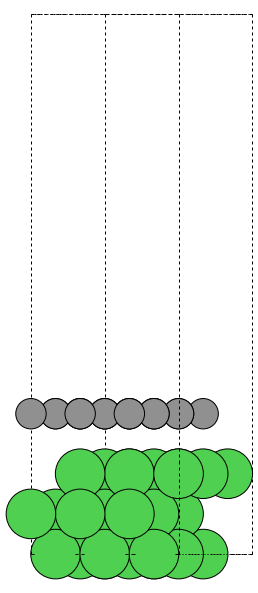
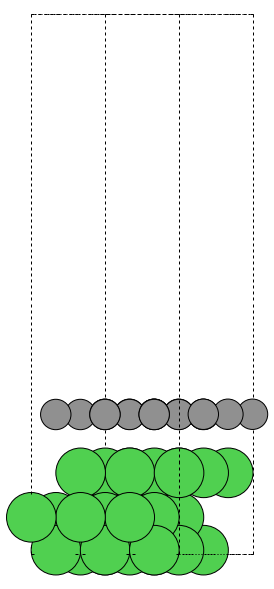

In [29]:
import base64
from ase.io import write
from ase.build import make_supercell
from IPython.display import HTML
import io

def visualize_material_base64(material, title: str, rotation: str = '0x', number_of_repetitions: int = 3):
    """
    Returns an HTML string with a Base64-encoded image for visualization,
    including the name of the file, positioned horizontally.
    """
    # Set the number of unit cell repetition for the structure
    n = number_of_repetitions
    material_repeat = make_supercell(material, [[n,0,0],[0,n,0],[0,0,1]])
    text = f"{material.symbols} - {title}"

    # Write image to a buffer to display in HTML
    buf = io.BytesIO()
    write(buf, material_repeat, format='png', rotation=rotation)
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    html_str = f'''
    <div style="display: inline-block; margin: 10px; vertical-align: top;">
        <p>{text}</p>
        <img src="data:image/png;base64,{img_str}" alt="{title}" />
    </div>
    '''
    return html_str

html_original = visualize_material_base64(ase_original_interface, "original", "-90x")
html_relaxed = visualize_material_base64(ase_final_interface, "relaxed", "-90x")

# Display the interfaces before and after relaxation
html_content = f'<div style="display: flex;">{html_original}{html_relaxed}</div>'
display(HTML(html_content))


### 7.3. Calculate energy energy using matgl M3GNet

In [31]:
nickel_relaxed_interface = ase_final_interface.copy()
graphene_relaxed_interface = ase_final_interface.copy()
nickel_original_interface = ase_original_interface.copy()
graphene_original_interface = ase_original_interface.copy()

del nickel_relaxed_interface[[atom.index for atom in nickel_relaxed_interface if atom.symbol != 'Ni']]
del graphene_relaxed_interface[[atom.index for atom in graphene_relaxed_interface if atom.symbol != 'C']]
del nickel_original_interface[[atom.index for atom in nickel_original_interface if atom.symbol != 'Ni']]
del graphene_original_interface[[atom.index for atom in graphene_original_interface if atom.symbol != 'C']]

#set EMT calculator
nickel_relaxed_interface.set_calculator(calc)
graphene_relaxed_interface.set_calculator(calc)
nickel_original_interface.set_calculator(calc)
graphene_original_interface.set_calculator(calc)

original_substrate_energy = nickel_original_interface.get_total_energy()
original_layer_energy = graphene_original_interface.get_total_energy()
relaxed_substrate_energy = nickel_relaxed_interface.get_total_energy()
relaxed_layer_energy = graphene_relaxed_interface.get_total_energy()

delta_original = relaxed_energy - original_substrate_energy - original_layer_energy
delta_relaxed = relaxed_energy - relaxed_substrate_energy - relaxed_layer_energy

# calculate area of interface
area = ase_original_interface.get_volume() / ase_original_interface.cell[2, 2]
print(area)

effective_delta_relaxed = (relaxed_energy * ase_final_interface.get_global_number_of_atoms() -
                           nickel_relaxed_interface.get_global_number_of_atoms() * relaxed_substrate_energy -
                           graphene_relaxed_interface.get_global_number_of_atoms() * relaxed_layer_energy)/(2 * area * ase_final_interface.get_global_number_of_atoms())
print(ase_final_interface.get_global_number_of_atoms())
print(nickel_relaxed_interface.get_global_number_of_atoms())
print(graphene_relaxed_interface.get_global_number_of_atoms())
# print(f"Original interface energy: {ase_original_interface.get_total_energy():.4f} eV")
print(f"Relaxed interface energy: {relaxed_energy:.4f} eV")
print(f"Original Substrate energy: {original_substrate_energy:.4f} eV")
print(f"Original Layer energy: {original_layer_energy:.4f} eV")
print(f"Original Delta: {delta_original:.4f} eV")
print(f"Original Delta per area: {delta_original / area:.4f} eV/Ang^2")
print(f"Relaxed Substrate energy: {relaxed_substrate_energy:.4f} eV")
print(f"Relaxed Layer energy: {relaxed_layer_energy:.4f} eV")
print(f"Relaxed Delta: {delta_relaxed:.4f} eV")
print(f"Relaxed Delta per area: {delta_relaxed / area:.4f} eV/Ang^2")
print(f"Effective relaxed Delta per area: {effective_delta_relaxed:.4f} eV/Ang^2")


print(ase_to_poscar(ase_final_interface))
print(ase_to_poscar(nickel_relaxed_interface))
print(ase_to_poscar(graphene_relaxed_interface))
print(ase_to_poscar(nickel_original_interface))
print(ase_to_poscar(graphene_original_interface))

5.240839288055053
5
3
2
Relaxed interface energy: -18.1053 eV
Original Substrate energy: -2.6920 eV
Original Layer energy: -15.4182 eV
Original Delta: 0.0049 eV
Original Delta per area: 0.0009 eV/Ang^2
Relaxed Substrate energy: -2.6684 eV
Relaxed Layer energy: -15.4182 eV
Relaxed Delta: -0.0187 eV
Relaxed Delta per area: -0.0036 eV/Ang^2
Effective relaxed Delta per area: -0.9862 eV/Ang^2
Ni  C 
 1.0000000000000000
     2.4599995727812636    0.0000000000000000    0.0000000000000002
     1.2299995285143268    2.1304228448014668    0.0000000000000002
     0.0000000000000000    0.0000000000000000   27.0171631046722780
 Ni  C  
   3   2
Cartesian
  1.2300027025647622  0.7101431378908720  0.1948863120965003
  0.0000122416025937  0.0000077319999213  1.8379527731385130
  2.4657495023575300  1.4236022556285031  4.0614048789710475
 -0.0108452190571857 -0.0062635946350369  6.9907350485416675
  1.2221636434393375  0.7056186683932514  6.9790081204315761

Ni 
 1.0000000000000000
     2.4599995727812

## References

[1] ASE alignn calculator relaxation example: https://github.com/usnistgov/alignn?tab=readme-ov-file#alignnff 
[2] Plotly 3D molecular visualization: https://dash.plotly.com/dash-bio/molecule3dviewer